In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Load the weather dataset
weather_data = pd.read_csv('/content/weather_dataset.csv')

# Convert the 'datetime' column to a datetime object
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

# Set 'datetime' column as the index
weather_data.set_index('datetime', inplace=True)

# Define the target date for training
target_date = pd.to_datetime('2024-02-20')

weather_data.head()




,name,temp,tempmin,tempmax,humidity,precip,windspeed
datetime,,,,,,,
2004-01-01,east godavari,23.1,19.1,26.4,76.8,0,7.6
2004-01-02,east godavari,23.2,19.9,26.4,76.9,0,3.6
2004-01-03,east godavari,23.3,19.1,26.4,73.8,0,5.4
2004-01-04,east godavari,23.0,19.2,26.4,72.8,0,11.2
2004-01-05,east godavari,23.3,18.9,26.4,70.9,0,14.8


ADF Statistic for temp: -6.71959986886969
p-value for temp: 3.5103996538003396e-09


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


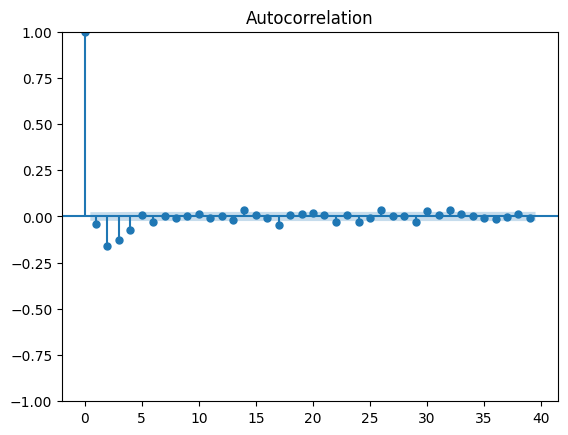

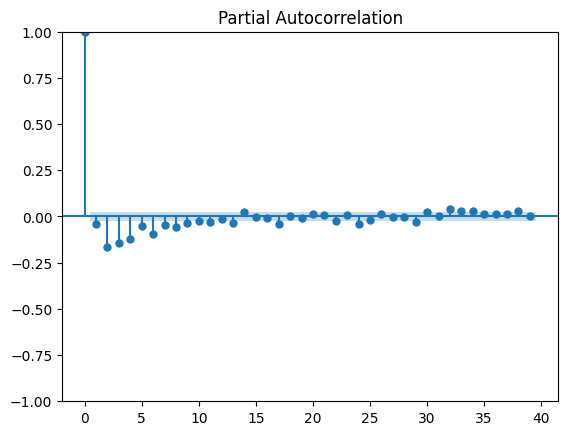

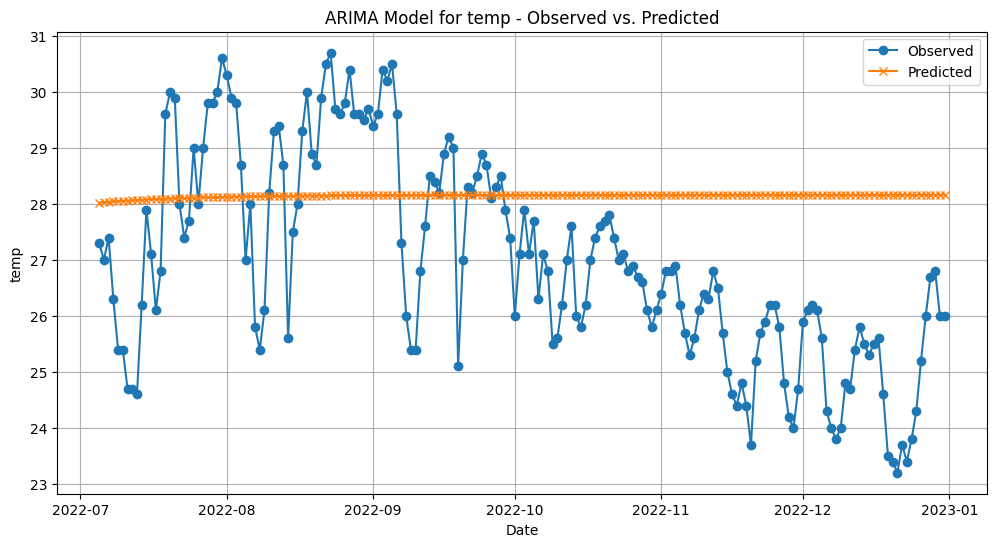

ADF Statistic for humidity: -7.542161608578894
p-value for humidity: 3.3558578952708745e-11


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


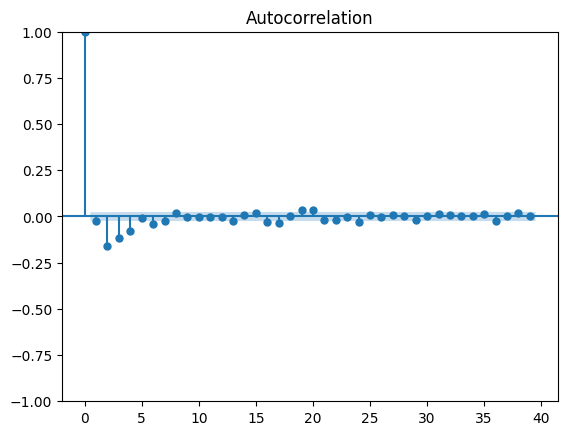

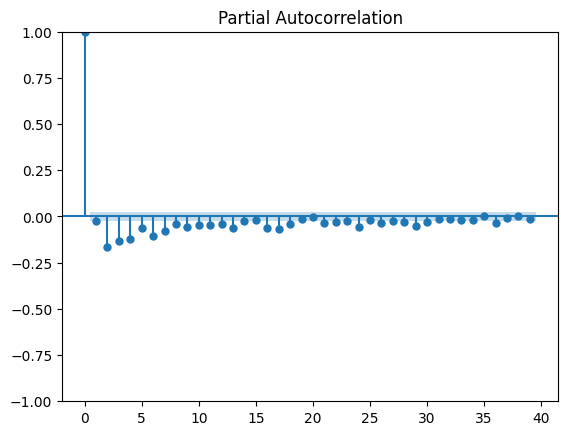

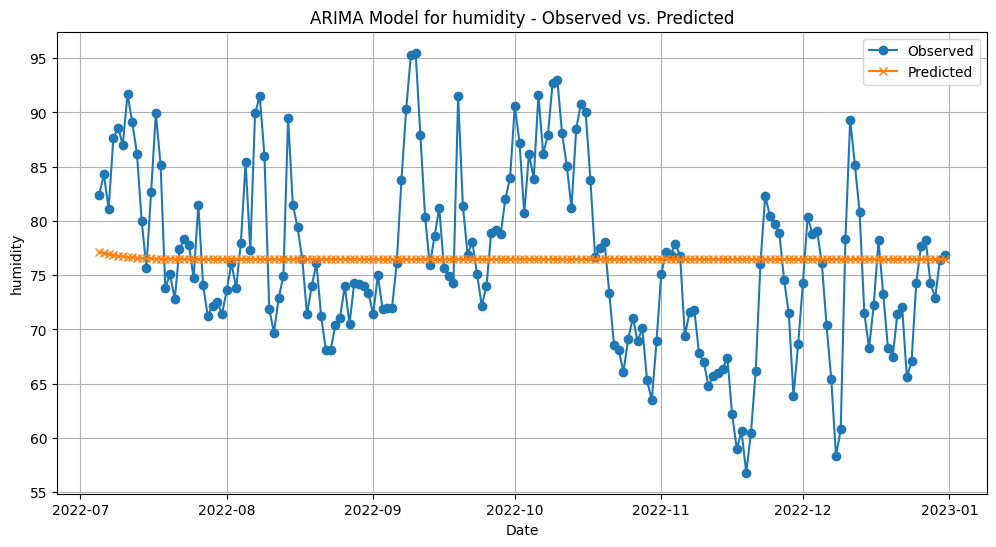

ADF Statistic for precip: -10.169838301771083
p-value for precip: 7.137668183263063e-18


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


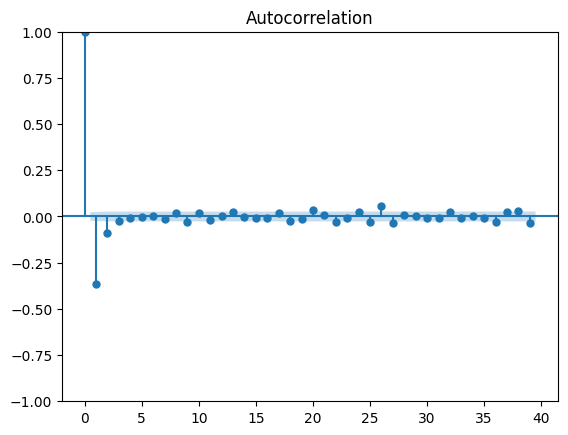

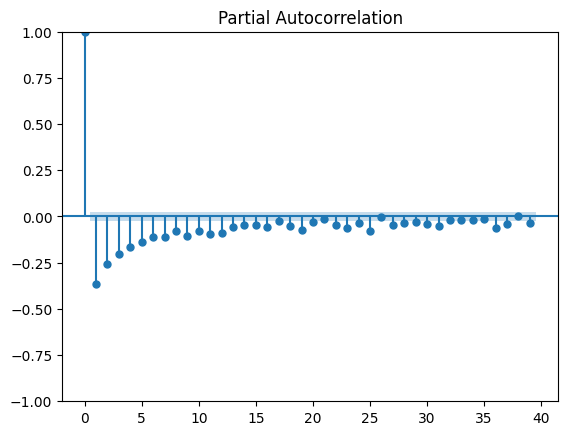

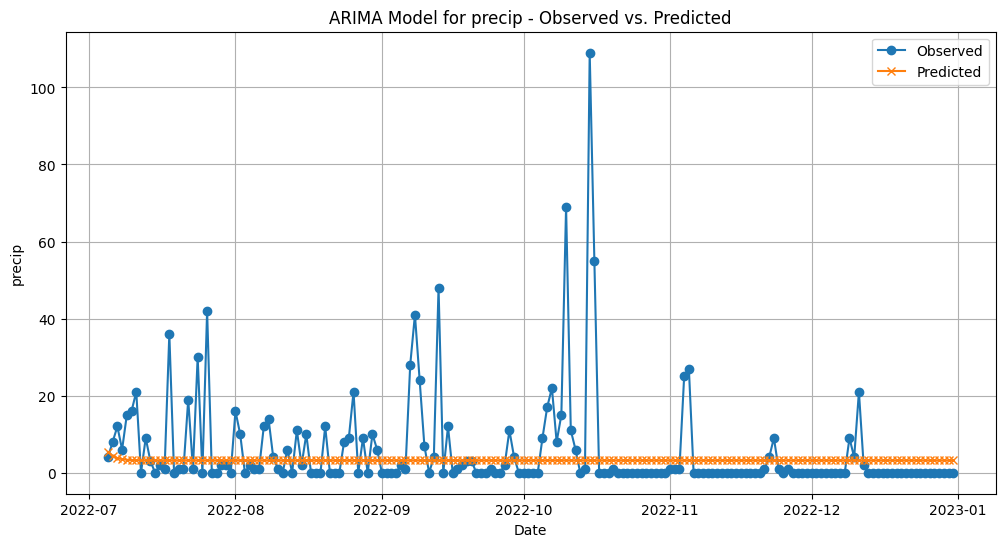

In [ ]:
# Select the relevant weather features
weather_features = ['temp', 'humidity', 'precip']

# Initialize dictionaries to store forecasted values and summary statistics
forecasted_data = {}
summary_statistics = {}

# Loop through each weather feature
for feature in weather_features:
    # Extract the target data for the current feature
    data_target = weather_data[feature]

    # Split the data into training and testing sets
    train_data = data_target.iloc[:-180]  # Use all except the last 180 days for training
    test_data = data_target.iloc[-180:]   # Use the last 180 days for testing

    # Check if the data is stationary
    result = adfuller(data_target)
    print(f'ADF Statistic for {feature}: {result[0]}')
    print(f'p-value for {feature}: {result[1]}')

    # Plot ACF and PACF for parameter selection (you can adjust p and q based on the plots)
    plot_acf(data_target.diff().dropna())  # Autocorrelation Function
    plot_pacf(data_target.diff().dropna())  # Partial Autocorrelation Function

    # Define and fit the ARIMA model for training data
    model = ARIMA(train_data, order=(1, 0, 1))  # You can adjust the order (p, d, q) as needed
    model_fit = model.fit()
    model_fit.summary()

    # Make predictions for the test period
    predictions = model_fit.forecast(steps=len(test_data))

    # Create a date range for the test period
    test_date_range = pd.date_range(start=test_data.index[0], periods=len(test_data))

    # Plot the observed vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(test_date_range, test_data, label='Observed', marker='o')
    plt.plot(test_date_range, predictions, label='Predicted', marker='x')
    plt.title(f'ARIMA Model for {feature} - Observed vs. Predicted')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Store forecasted values for the current feature
    forecasted_data[feature] = predictions

    # Calculate summary statistics for the forecasted data
    mean_forecast = predictions.mean()
    min_forecast = predictions.min()
    max_forecast = predictions.max()
    summary_statistics[feature] = {
        'Mean Forecast': mean_forecast,
        'Min Forecast': min_forecast,
        'Max Forecast': max_forecast
    }



In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize a dictionary to store RMSE values for each feature
rmse_values = {}

# Loop through each weather feature
for feature in weather_features:
    # Extract the test data for the current feature
    test_data = weather_data[feature].iloc[-180:]  # Use the last 180 days for testing

    # Extract the corresponding forecasted data
    forecasted_values = forecasted_data[feature]

    # Calculate the Mean Squared Error (MSE)
    mse = mean_squared_error(test_data, forecasted_values)

    # Calculate the Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Store the RMSE value for the current feature
    rmse_values[feature] = rmse

# Print the RMSE values for each feature
print("\nRoot Mean Squared Error (RMSE) for Forecasted Weather Features:")
for feature, rmse in rmse_values.items():
    print(f"{feature}: RMSE = {rmse:.2f}")
    print("     ")





Root Mean Squared Error (RMSE) for Forecasted Weather Features:
temp: RMSE = 2.20
     
humidity: RMSE = 7.99
     
precip: RMSE = 13.23
     


In [ ]:

# Calculate similarity scores and recommend crops based on the forecasted weather features
future_weather_data = {
    'temperature': summary_statistics['temp']['Mean Forecast'],
    'humidity': summary_statistics['humidity']['Mean Forecast'],
    'rainfall': summary_statistics['precip']['Mean Forecast']
}

crop_data_ = pd.read_csv('/content/finalcrop data set.csv')

# Shuffle the dataset
crop_data = crop_data_.sample(frac=1, random_state=42)  # frac=1 shuffles the entire dataset

# Select features (N, P, K, pH, temperature, humidity, rainfall, soil type)
X = crop_data.drop(columns=['label'])
y = crop_data['label']  # Crop labels (the target variable)

# Encode categorical variables (soiltype) using one-hot encoding
X_encoded = pd.get_dummies(X, columns=['soiltype'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize and train a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        78
   blackgram       1.00      1.00      1.00        14
    chickpea       1.00      1.00      1.00        44
     coconut       1.00      1.00      1.00        58
      coffee       1.00      1.00      1.00        54
      cotton       1.00      1.00      1.00        35
      lentil       1.00      1.00      1.00        17
       maize       1.00      1.00      1.00        40
       mango       0.99      1.00      0.99        73
    mungbean       1.00      1.00      1.00        42
      orange       1.00      1.00      1.00        20
  pigeonpeas       1.00      0.96      0.98        24
 pomegranate       1.00      1.00      1.00        86
        rice       1.00      1.00      1.00        39
   sugarcane       1.00      1.00      1.00        38
  watermelon       1.00      1.00      1.00        38

    accuracy                           1.00       700
   

In [ ]:


input_soil_type = input("Enter your soil type: ")
input_N = float(input("Enter the N value: "))
input_P = float(input("Enter the P value: "))
input_K = float(input("Enter the K value: "))
input_pH = float(input("Enter the pH value: "))

# Initialize a variable to keep track of the highest overall similarity score
highest_similarity_score = 0

# Initialize a variable to store the recommended crop
recommended_crop = None

# Loop through the crops in the dataset
for index, row in crop_data.iterrows():
    # Check if the soil type matches the input soil type
    if row['soiltype'] == input_soil_type:
        crop_weather_data = {
            'temperature': row['temperature'],
            'humidity': row['humidity'],
            'rainfall': row['rainfall']
        }

        # Calculate Euclidean distance between predicted and actual weather data
        weather_distance = np.sqrt(np.sum(np.square(np.array(list(future_weather_data.values())) - np.array(list(crop_weather_data.values())))))

        # Calculate Euclidean distance between input soil parameters and crop soil parameters
        soil_distance = np.sqrt((input_N - row['N'])**2 + (input_P - row['P'])**2 + (input_K - row['K'])**2 + (input_pH - row['ph'])**2)

        # Use the inverse of the distance as the similarity score for weather and soil
        weather_similarity_score = 1 / (1 + weather_distance)
        soil_similarity_score = 1 / (1 + soil_distance)

        # Calculate the overall similarity score as a weighted average
        overall_similarity_score = (weather_similarity_score + soil_similarity_score) / 2

        # Check if the current crop has a higher overall similarity score than the previous highest score
        if overall_similarity_score > highest_similarity_score:
            highest_similarity_score = overall_similarity_score
            recommended_crop = row['label']

# Print the recommended crop
if recommended_crop is not None:
    print(f"Recommended Crop for Soil Type '{input_soil_type}': {recommended_crop} (Overall Similarity Score: {highest_similarity_score:.2f})")
else:
    print(f"No matching crop found for Soil Type '{input_soil_type}'")



Enter your soil type: black soil
Enter the N value: 103
Enter the P value: 36
Enter the K value: 31
Enter the pH value: 6.67
Recommended Crop for Soil Type 'black soil': sugarcane (Overall Similarity Score: 0.07)
